In [1]:

import molmodmt as m3t
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

from openmmtools.integrators import LangevinIntegrator
import numpy as np
import os
import pickle as pickle

import matplotlib.pyplot as plt

/home/liliana/Myopt/Miniconda/miniconda3/envs/UIBCDF_lab/lib/python3.7/site-packages/yank/experiment.py:1170: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """)


#### Loading PDB

In [2]:
 modelo_HIF_termalizado= m3t.convert('HIF1_equilibrado_NVT.pdb', 'openmm.Modeller')

#### System

In [3]:
topology = modelo_HIF_termalizado.topology
forcefield = app.ForceField('amber99sbildn.xml','tip3p.xml')
system = forcefield.createSystem(topology, nonbondedMethod=app.PME, nonbondedCutoff=1.2*unit.nanometers, 
                        constraints=app.HBonds,rigidWater=True, ewaldErrorTolerance=0.0005)

#### Thermodynamic State

In [4]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300.0*unit.kelvin
pressure    = 1.0*unit.atmosphere

#### Integrator

In [5]:
friction   = 1.0/unit.picosecond
step_size  = 2.0*unit.femtoseconds
integrator = LangevinIntegrator(temperature, friction, step_size)
integrator.setConstraintTolerance(0.00001)

#### Barostat

In [6]:
barostat_interval = 25
barostat = mm.MonteCarloBarostat(pressure, temperature, barostat_interval)
system.addForce(barostat)

5

#### Platform

In [7]:
platform = mm.Platform.getPlatformByName('CUDA')
properties = {'CudaPrecision': 'mixed'}

#### Simulation

In [8]:
simulation = app.Simulation(topology, system, integrator, platform, properties)

#### Initial Conditions

In [9]:
restart_pkl = open("restart1.pkl","rb")

_, init_positions, init_velocities, init_box_vectors = pickle.load(restart_pkl)
init_positions = init_positions * unit.nanometers
init_velocities = init_velocities * unit.nanometers*unit.picoseconds
init_box_vectors = init_box_vectors * unit.nanometers

restart_pkl.close()

simulation.context.setPositions(init_positions)
simulation.context.setVelocities(init_velocities)

simulation.context.setPeriodicBoxVectors(*init_box_vectors)
#simulation.context.setPeriodicBoxVectors(init_box_vectors[0],init_box_vectors[1],init_box_vectors[2])


#### Iterations Parameters

In [10]:
time_simulation = 300.0 * unit.picoseconds
time_saving = 1.0 * unit.picoseconds
time_verbose = 1.0 * unit.picoseconds
time_checkpoint = 1.0 * unit.picoseconds

number_iterations = int(time_simulation/time_saving)
elapsed_iterations_verbose = int(time_verbose/time_saving)
elapsed_iterations_checkpoint = int(time_checkpoint/time_saving)
steps_per_iteration = int(time_saving/step_size)
total_simulation_steps = number_iterations*steps_per_iteration

#### Reporters

In [11]:
net_mass = 0.0 * unit.amu
for particle_index in range(system.getNumParticles()):
    net_mass += system.getParticleMass(particle_index)

net_mass = net_mass.in_units_of(unit.gram/unit.mole)/unit.AVOGADRO_CONSTANT_NA

n_degrees_of_freedom = 3*system.getNumParticles() - system.getNumConstraints()

In [12]:
number_states_saved = number_iterations+1
data = dict()
data['time'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.picoseconds)
data['potential'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.kilocalories_per_mole)
data['kinetic'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.kilocalories_per_mole)
data['volume'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.nanometers**3)
data['density'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.gram / unit.centimeters**3)
data['kinetic_temperature'] = unit.Quantity(np.zeros([number_states_saved], np.float64), unit.kelvin)

#### Simulation Status

In [13]:
def printout_status(iteration, number_iterations, time, kinetic_temperature, volume):
    progression = 100.0*(iteration/number_iterations)
    msg="Progress: {:6.2f}%, Time: {:.2f} ps, Kinetic Temperature: {:.3f} K, Volume: {:.3f} nm^3"
    print(msg.format(progression, time.value_in_unit(unit.picoseconds),
                  kinetic_temperature.value_in_unit(unit.kelvin), volume.value_in_unit(unit.nanometers**3))) 

#### CheckPoint and Finnal State

In [14]:
def dump_state(simulation, filename):

    state = simulation.context.getState(getPositions=True, getVelocities=True)
    time = state.getTime() / unit.picoseconds
    positions = state.getPositions() / unit.nanometers
    velocities = state.getVelocities() / unit.nanometers*unit.picoseconds
    box_vectors = state.getPeriodicBoxVectors() / unit.nanometers

    with open(os.path.join(filename), 'wb') as f:
        pickle.dump((time, positions, velocities, box_vectors), f)

def save_checkpoint_state(simulation):
    return dump_state(simulation, "checkpoint.pkl")

def save_finnal_state(simulation):
    return dump_state(simulation, "continuation.pkl")

#### Reporting Initial State

In [15]:
state = simulation.context.getState(getEnergy=True)
time = state.getTime()
potential_energy = state.getPotentialEnergy()
kinetic_energy = state.getKineticEnergy()
volume = state.getPeriodicBoxVolume()
density = (net_mass / volume).in_units_of(unit.gram / unit.centimeter**3)
kinetic_temperature = (2.0 * kinetic_energy / kB / n_degrees_of_freedom).in_units_of(unit.kelvin)
data['time'][0] = time
data['potential'][0] = potential_energy
data['kinetic'][0] = kinetic_energy
data['volume'][0] = volume
data['density'][0] = density
data['kinetic_temperature'][0] = kinetic_temperature

printout_status(0, number_iterations, time, kinetic_temperature, volume)

Progress:   0.00%, Time: 0.00 ps, Kinetic Temperature: 297.374 K, Volume: 2096.309 nm^3


#### Running Simulation

In [16]:
for iteration in range(1, number_iterations+1):
    integrator.step(steps_per_iteration)
    state = simulation.context.getState(getEnergy=True)
    time = state.getTime()
    potential_energy = state.getPotentialEnergy()
    kinetic_energy = state.getKineticEnergy()
    volume = state.getPeriodicBoxVolume()
    density = (net_mass / volume).in_units_of(unit.gram / unit.centimeter**3)
    kinetic_temperature = (2.0 * kinetic_energy / kB / n_degrees_of_freedom).in_units_of(unit.kelvin)
    data['time'][iteration]=time
    data['potential'][iteration] = potential_energy
    data['kinetic'][iteration] = kinetic_energy
    data['volume'][iteration] = volume
    data['density'][iteration] = density
    data['kinetic_temperature'][iteration] = kinetic_temperature
    if (iteration%elapsed_iterations_verbose)==0:
        printout_status(iteration, number_iterations, time, kinetic_temperature, volume)
    if (iteration%elapsed_iterations_checkpoint)==0:
        save_checkpoint_state(simulation)

Progress:   0.33%, Time: 1.00 ps, Kinetic Temperature: 298.596 K, Volume: 2046.319 nm^3
Progress:   0.67%, Time: 2.00 ps, Kinetic Temperature: 298.122 K, Volume: 2029.295 nm^3
Progress:   1.00%, Time: 3.00 ps, Kinetic Temperature: 299.095 K, Volume: 2002.021 nm^3
Progress:   1.33%, Time: 4.00 ps, Kinetic Temperature: 297.904 K, Volume: 1977.610 nm^3
Progress:   1.67%, Time: 5.00 ps, Kinetic Temperature: 298.905 K, Volume: 1970.312 nm^3
Progress:   2.00%, Time: 6.00 ps, Kinetic Temperature: 298.860 K, Volume: 1961.172 nm^3
Progress:   2.33%, Time: 7.00 ps, Kinetic Temperature: 297.659 K, Volume: 1960.764 nm^3
Progress:   2.67%, Time: 8.00 ps, Kinetic Temperature: 298.555 K, Volume: 1960.222 nm^3
Progress:   3.00%, Time: 9.00 ps, Kinetic Temperature: 297.296 K, Volume: 1959.714 nm^3
Progress:   3.33%, Time: 10.00 ps, Kinetic Temperature: 297.159 K, Volume: 1958.946 nm^3
Progress:   3.67%, Time: 11.00 ps, Kinetic Temperature: 298.508 K, Volume: 1957.089 nm^3
Progress:   4.00%, Time: 12.00

#### Savind Data

In [17]:
with open(os.path.join('data.pkl'), 'wb') as f:
    pickle.dump(data, f)

#### Saving Finnal State

In [18]:
save_finnal_state(simulation)
m3t.convert(simulation,'HIF1_equilibrado_NPT.pdb')

#### Representando los datos

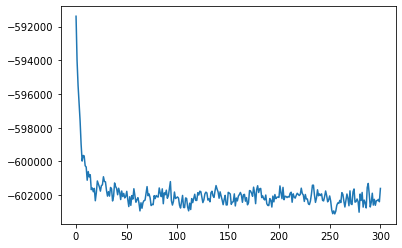

In [19]:
plt.plot(data['time'], data['potential'])

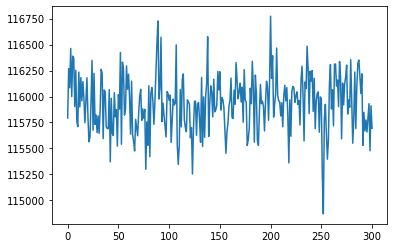

In [20]:
plt.plot(data['time'], data['kinetic'])

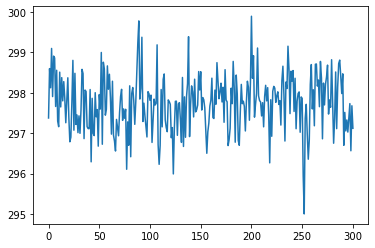

In [21]:
plt.plot(data['time'], data['kinetic_temperature'])

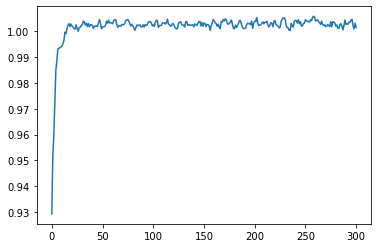

In [22]:
plt.plot(data['time'], data['density'])

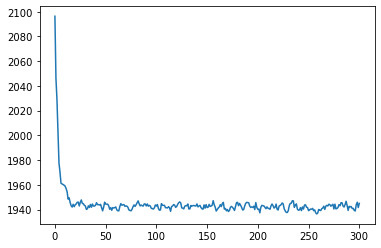

In [23]:
plt.plot(data['time'], data['volume'])